In [20]:
import sys
sys.path.append("../src/")
import warnings
warnings.filterwarnings("ignore")

from eddies_detection import  get_traj_with_parcels, get_traj_with_scipy, find_eddies, find_eddies2, optimized_streamline
from plot_tools import StreamPlot
import numpy as np

d0 = 0
date_len = 5
stream_data_fname = "../data/data.nc"
runtime = 800   
delta_time = 5
particle_grid_step = 2

In [21]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

## Compute the list of path

In [22]:
list_path = []

for di in range(date_len):
    b = get_traj_with_scipy(d0+di, runtime, delta_time, particle_grid_step, stream_data_fname)
    
    bb = find_eddies(b)
    list_path.append(bb)

5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 


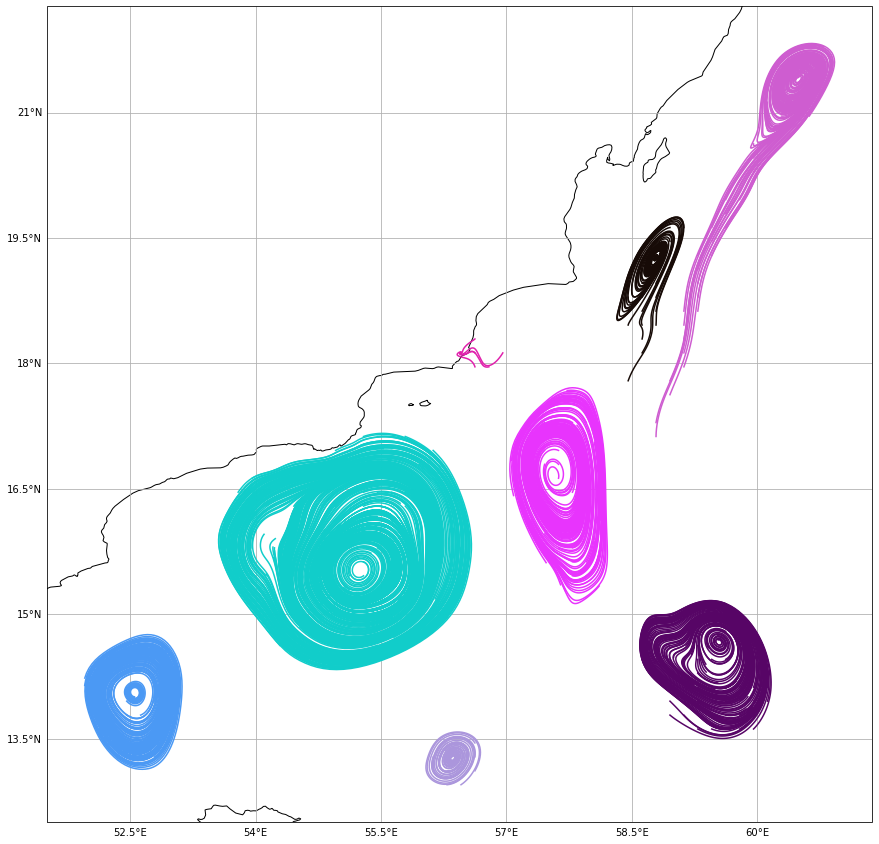

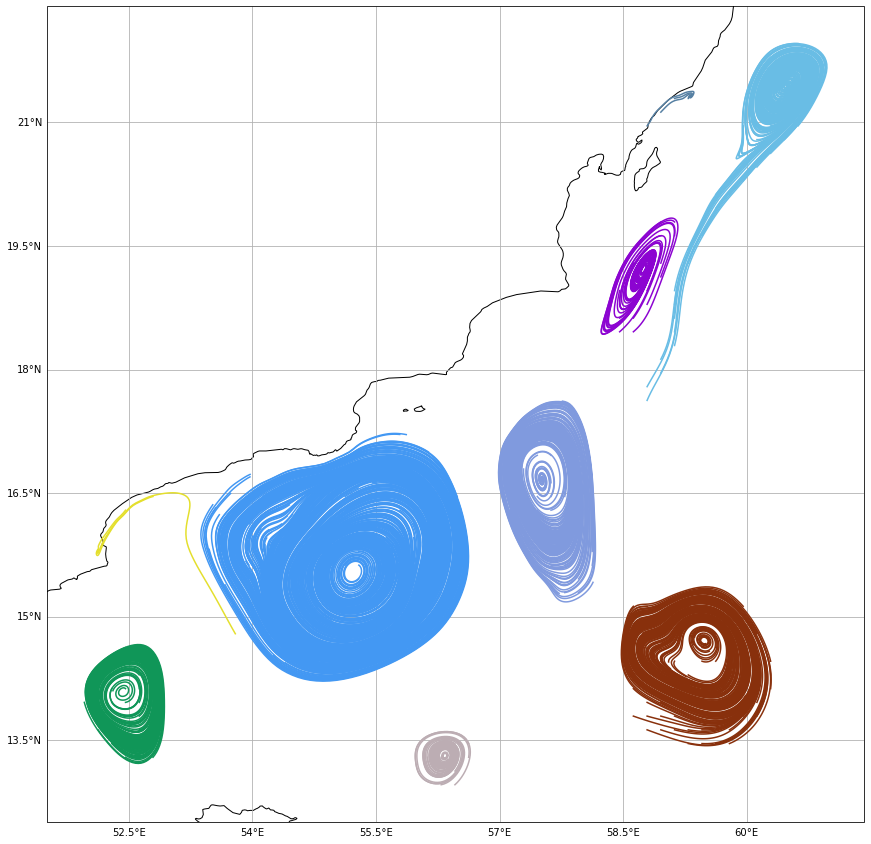

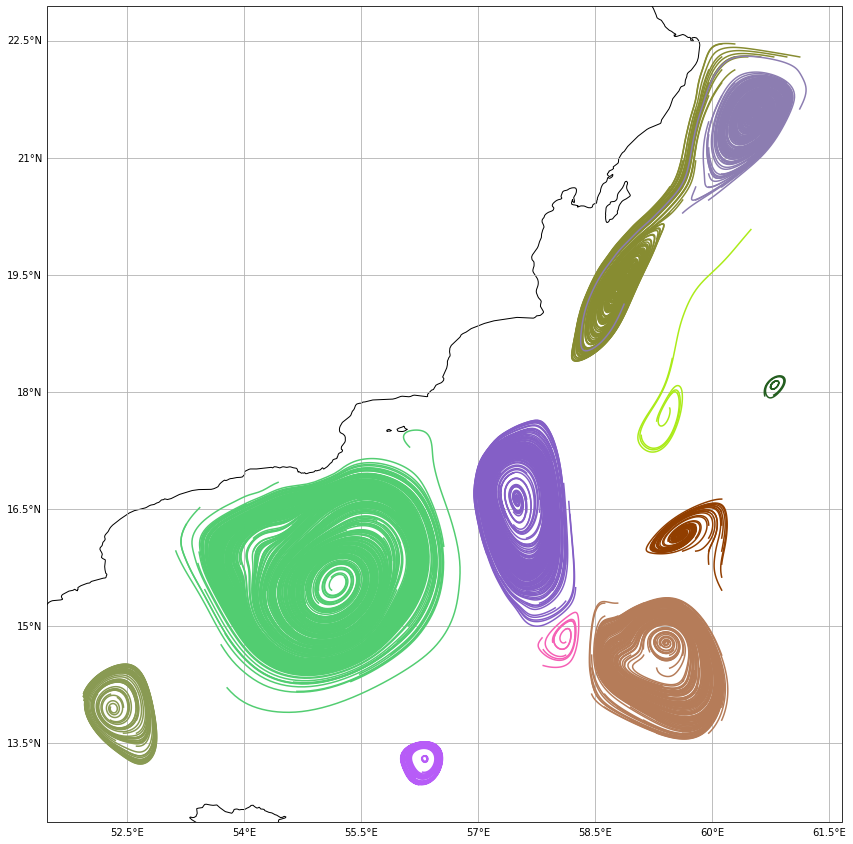

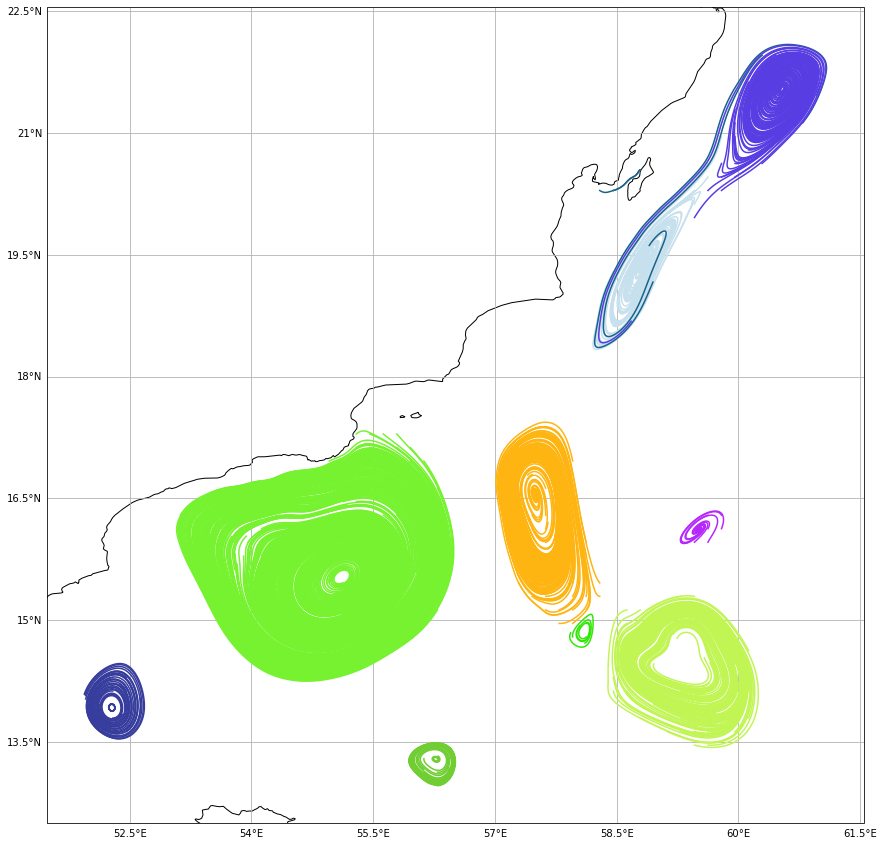

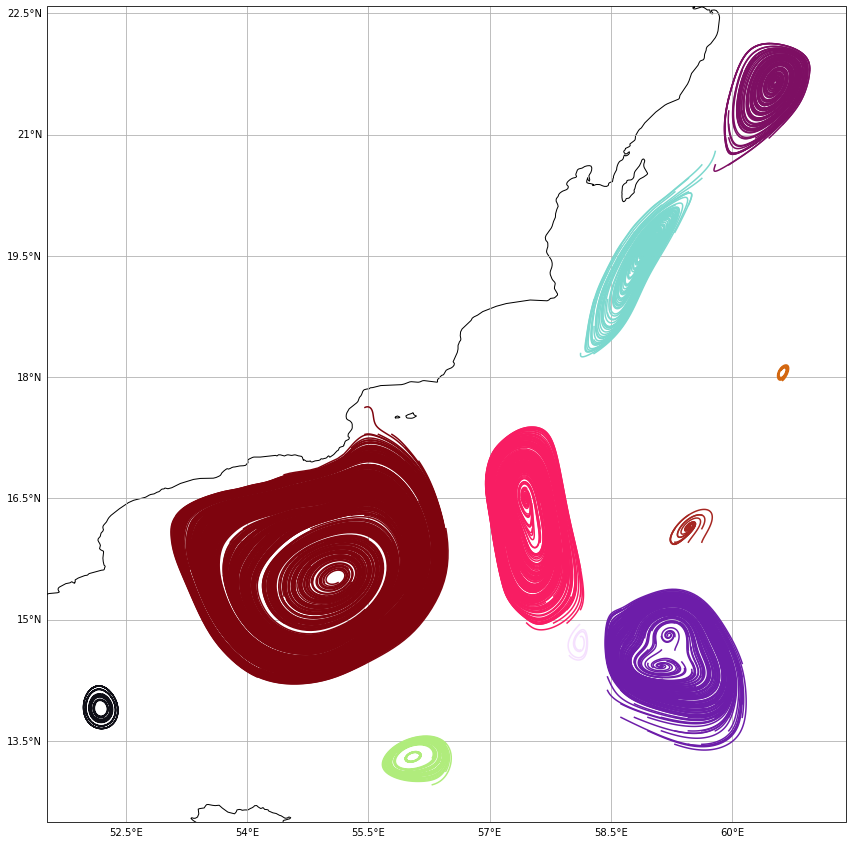

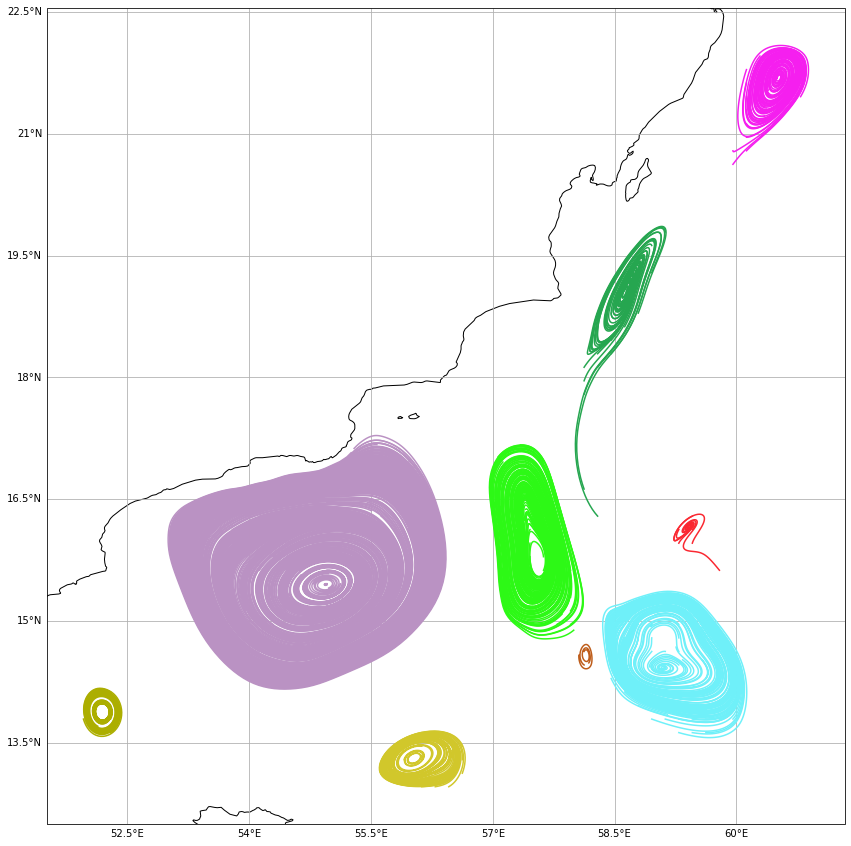

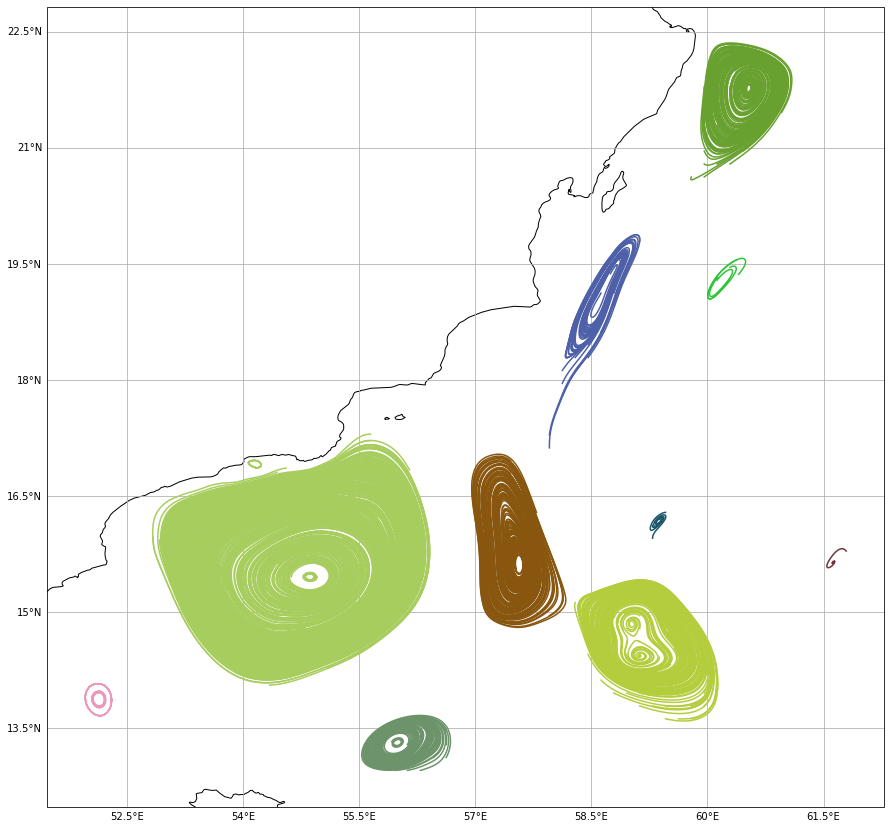

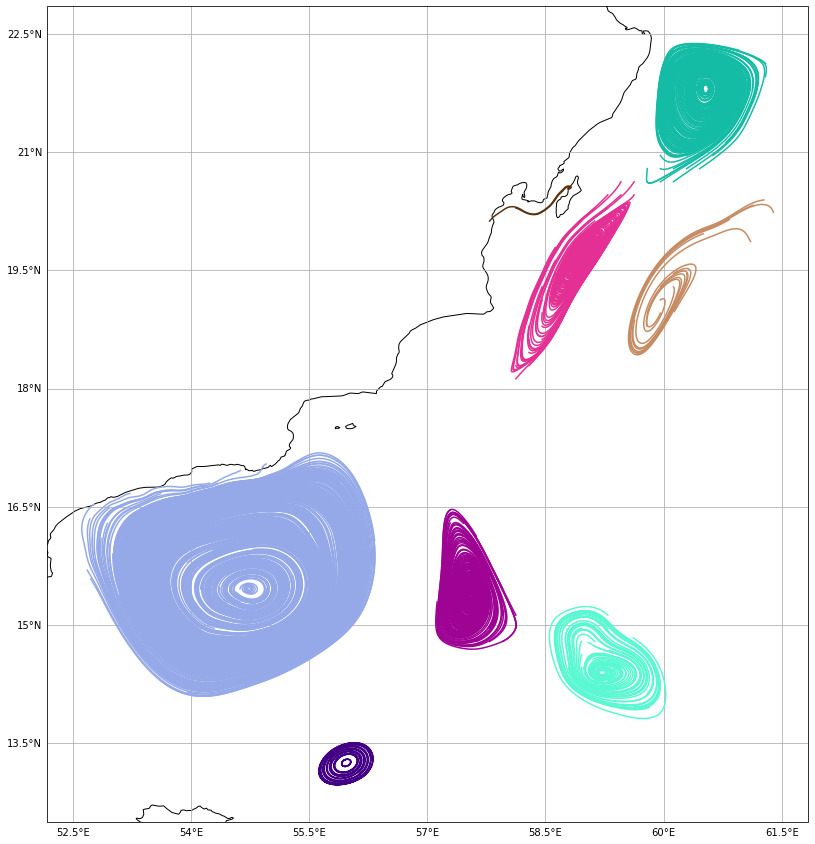

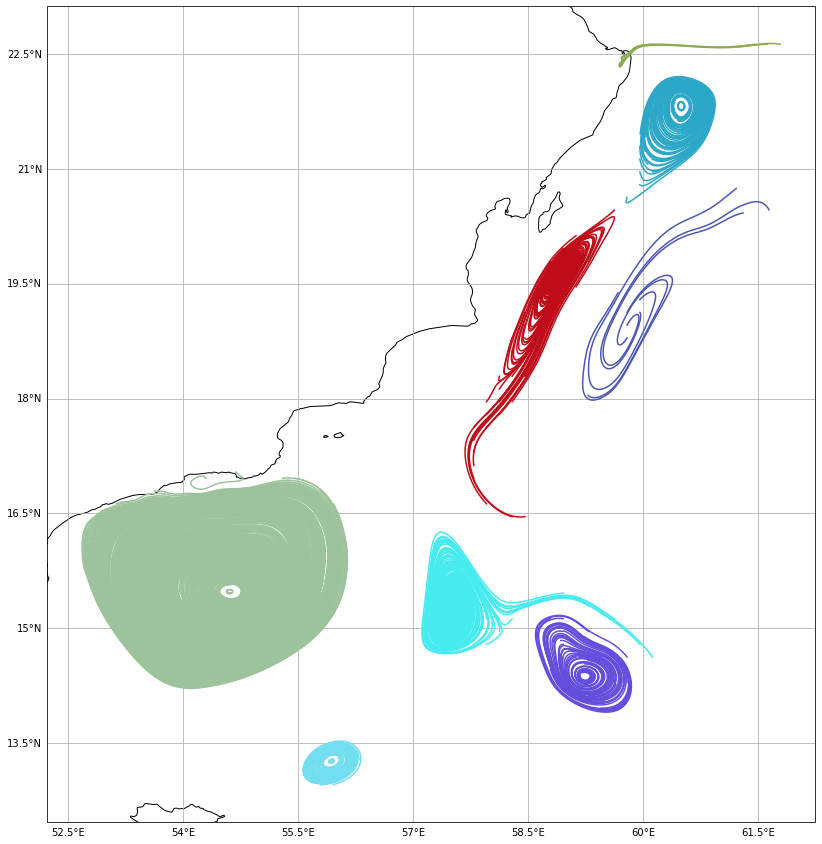

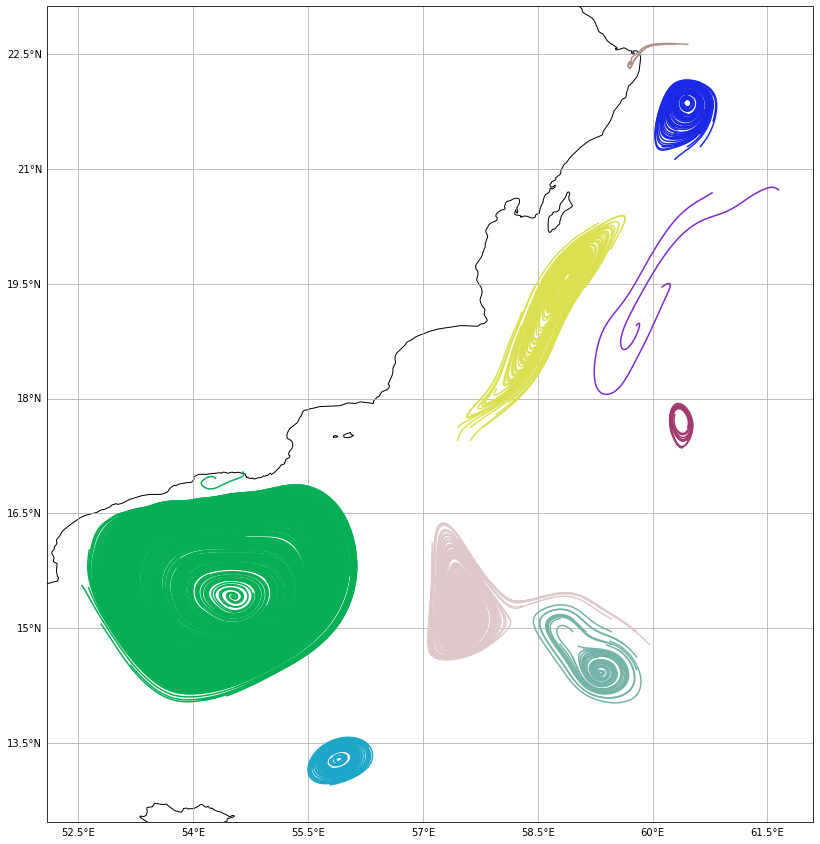

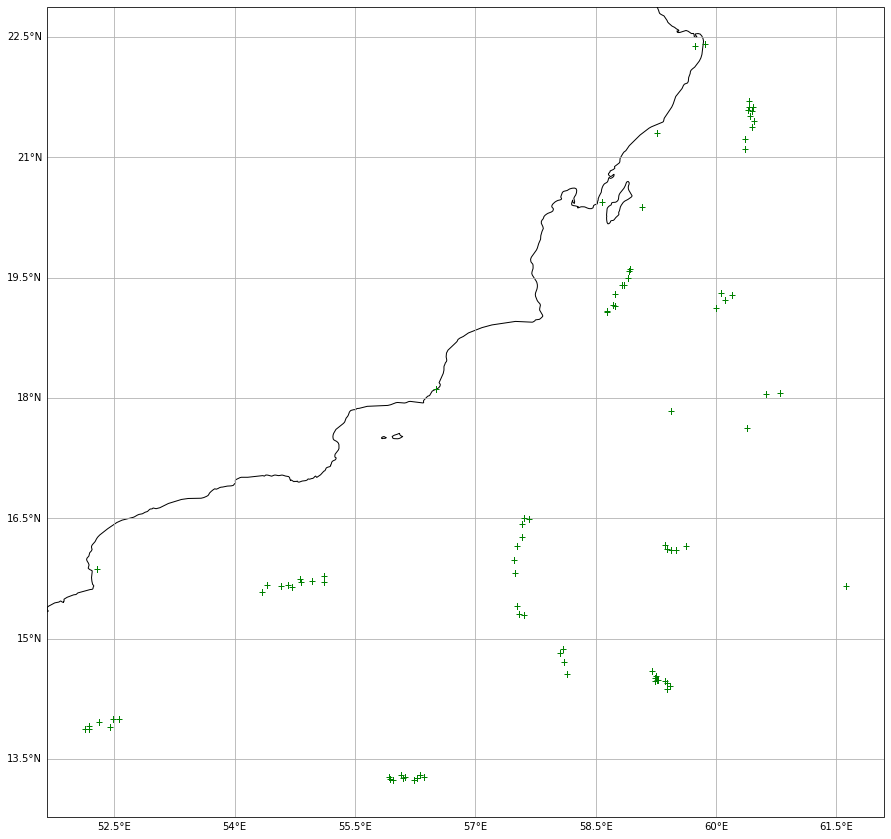

In [4]:
import random as rd


rd_color = lambda: '#{:02x}{:02x}{:02x}'.format(rd.randint(0,255),rd.randint(0,255),rd.randint(0,255))

for bb in list_path:
    figure = StreamPlot()
    for eddy in bb:
        line_style = rd_color()
        figure.plot_trajectories(eddy.sl_list,line_style=line_style)
    figure.show()

figure = StreamPlot()
for bb in list_path:
    figure.plot_eddies(bb,line_style='g+')

In [5]:
eddy = bb[0]
sl_list = eddy.sl_list
s = 0
n = 0
array_s = []
new_list_path = []
for bb in list_path:
    new_eddie = []
    n += len (bb)
    for eddy in bb:
        sl_list = eddy.sl_list
        s += len(sl_list)
        array_s.append(len(sl_list))
        if len(sl_list)>10:
            for i in sl_list:
                new_eddie.append(optimized_streamline(i,delta_time))

    new_bb = find_eddies(new_eddie)
    new_list_path.append(new_bb)

print("mean of the number of streamlines per eddies {}".format(s/n))

mean of the number of streamlines per eddies 54.05434782608695


In [6]:
p = array_s
print(min(p))
print(max(p))
print(np.quantile(p,[0.0,0.25,0.5,0.75,1.0]))

2
271
[  2.    7.5  31.5  67.  271. ]


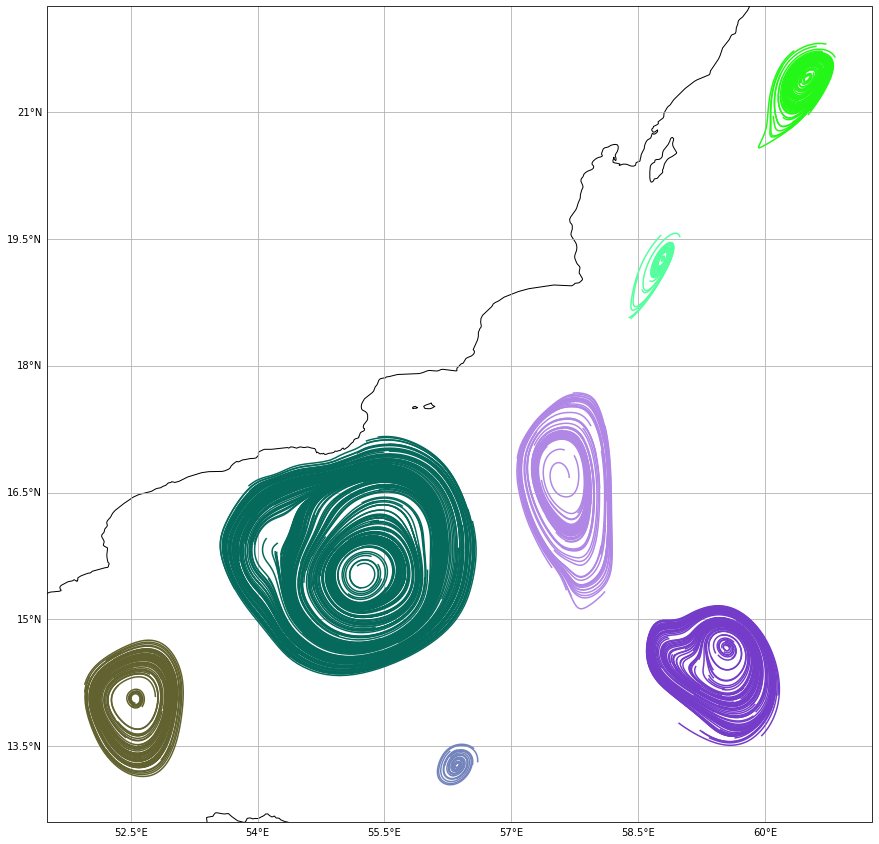

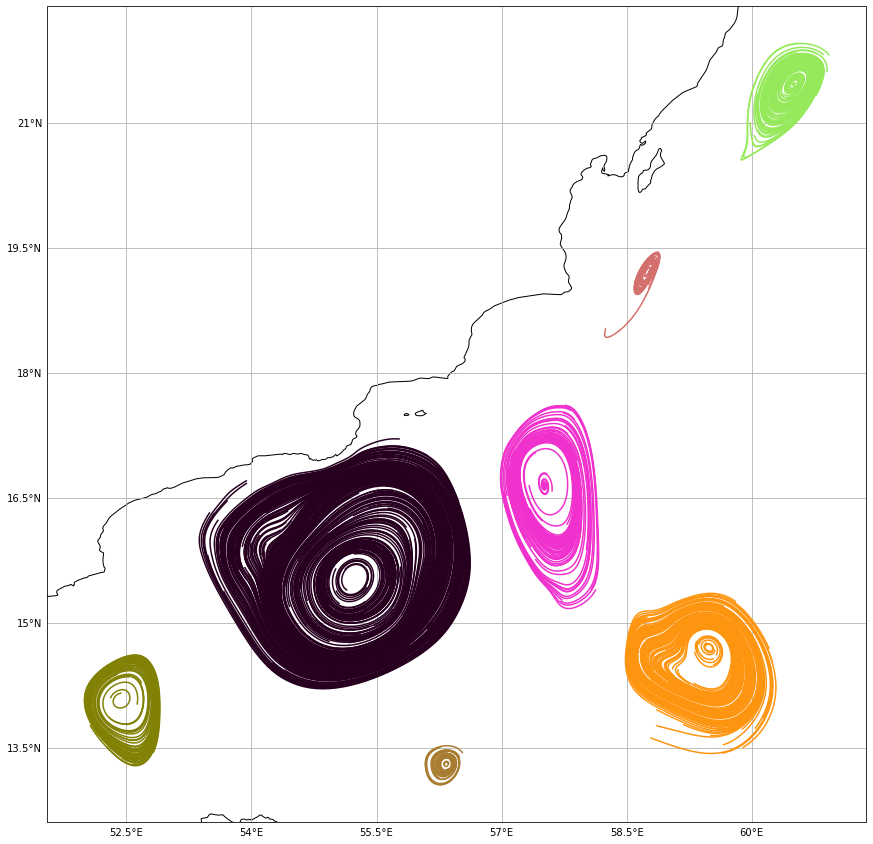

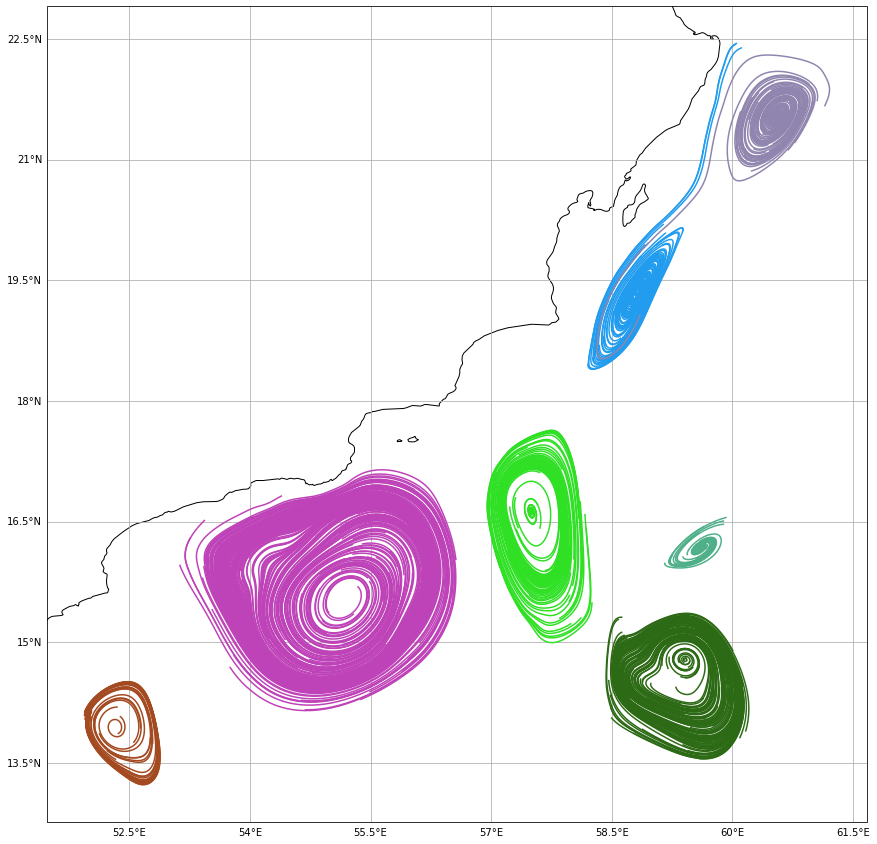

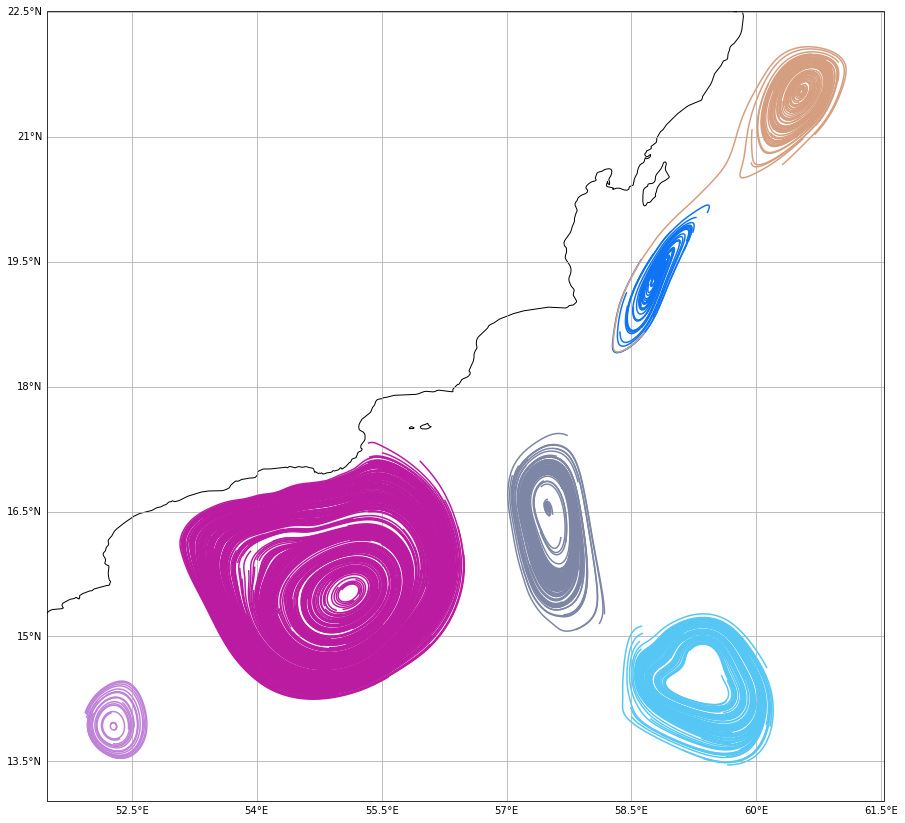

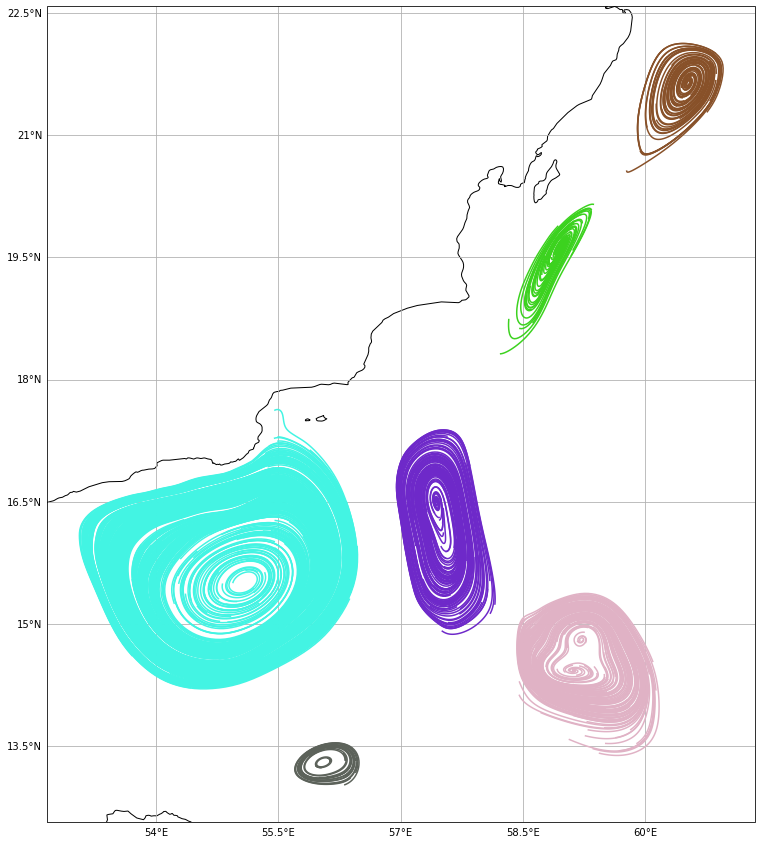

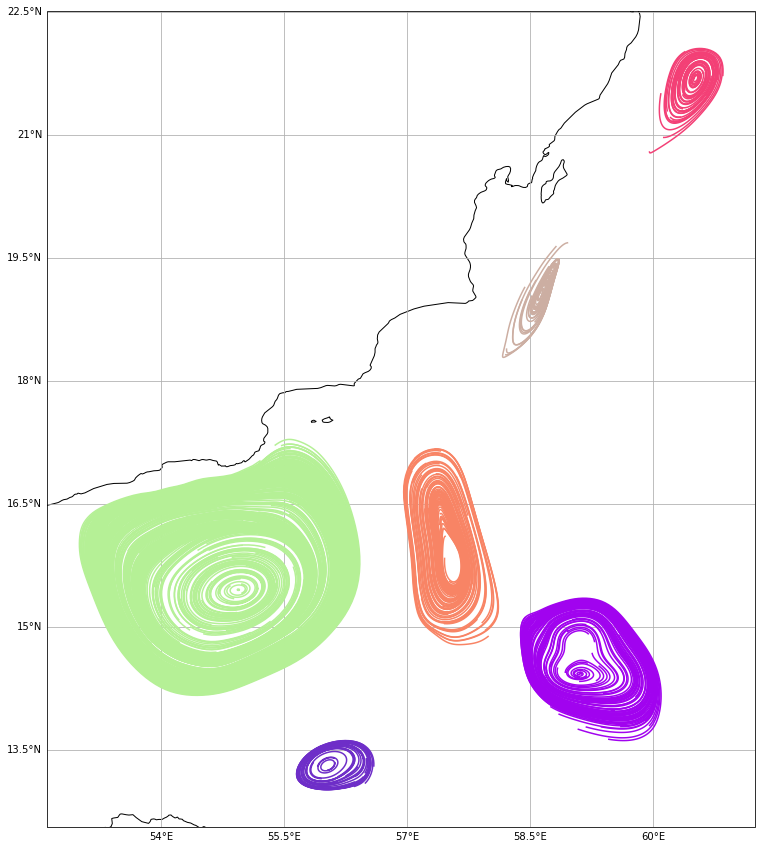

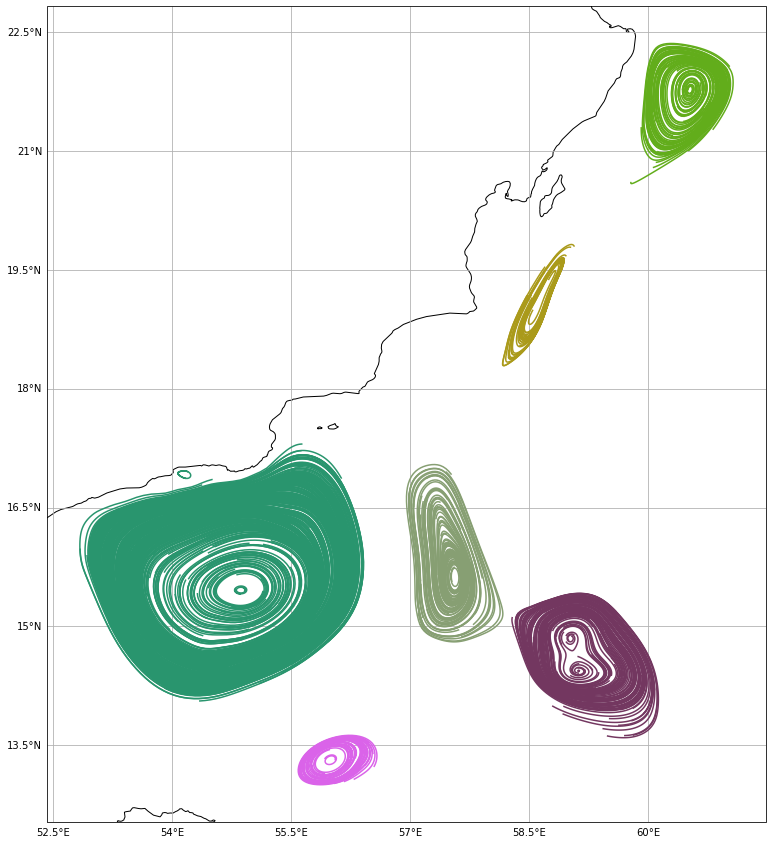

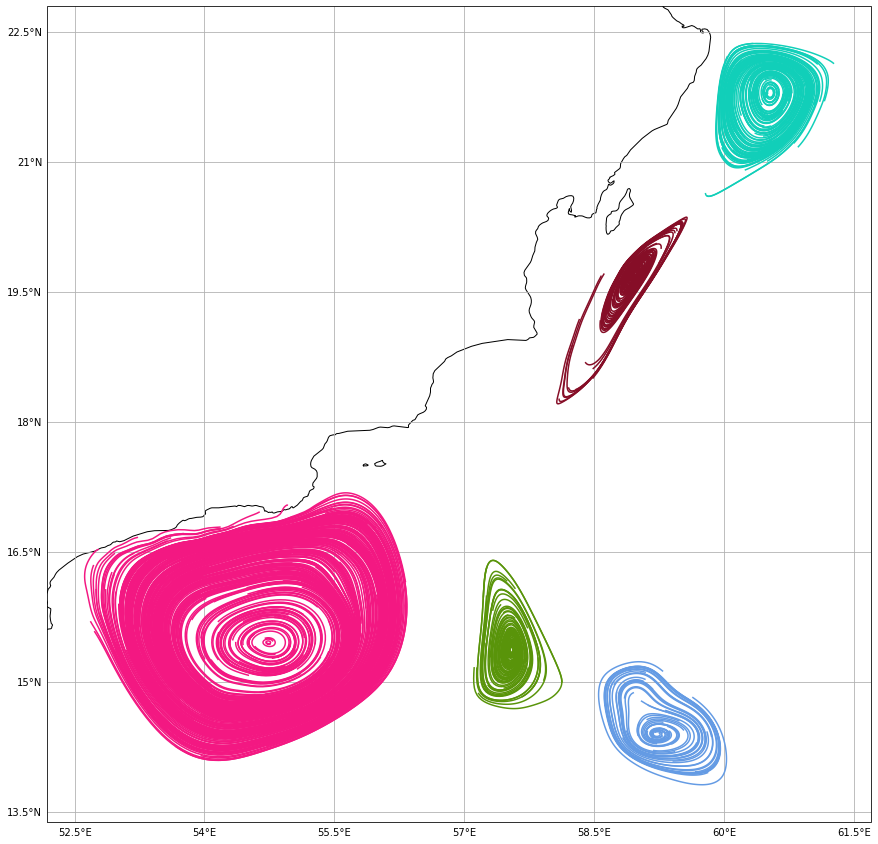

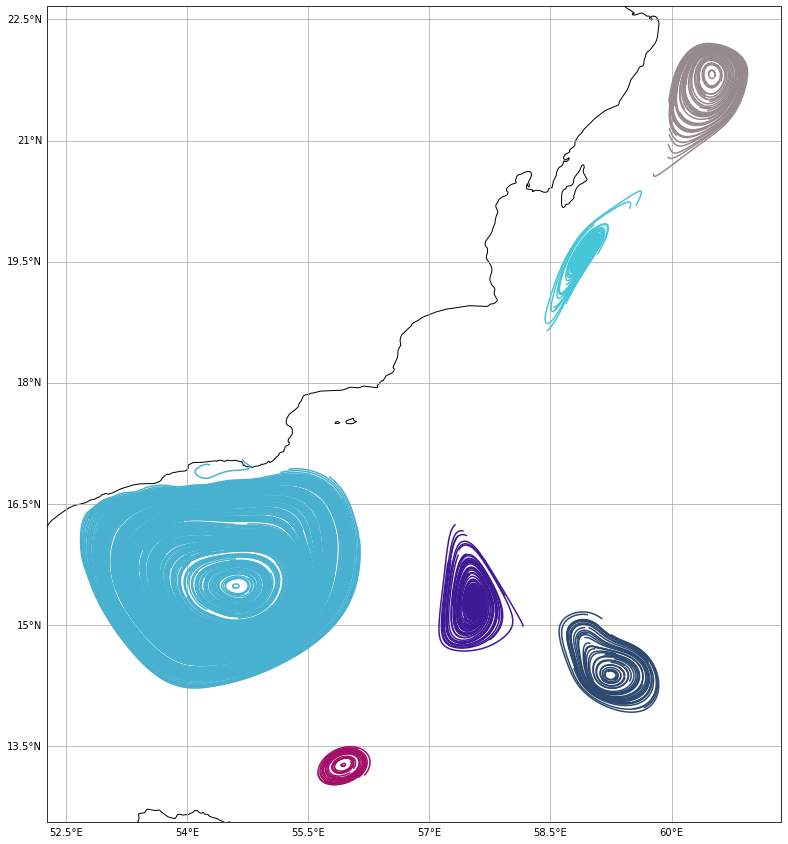

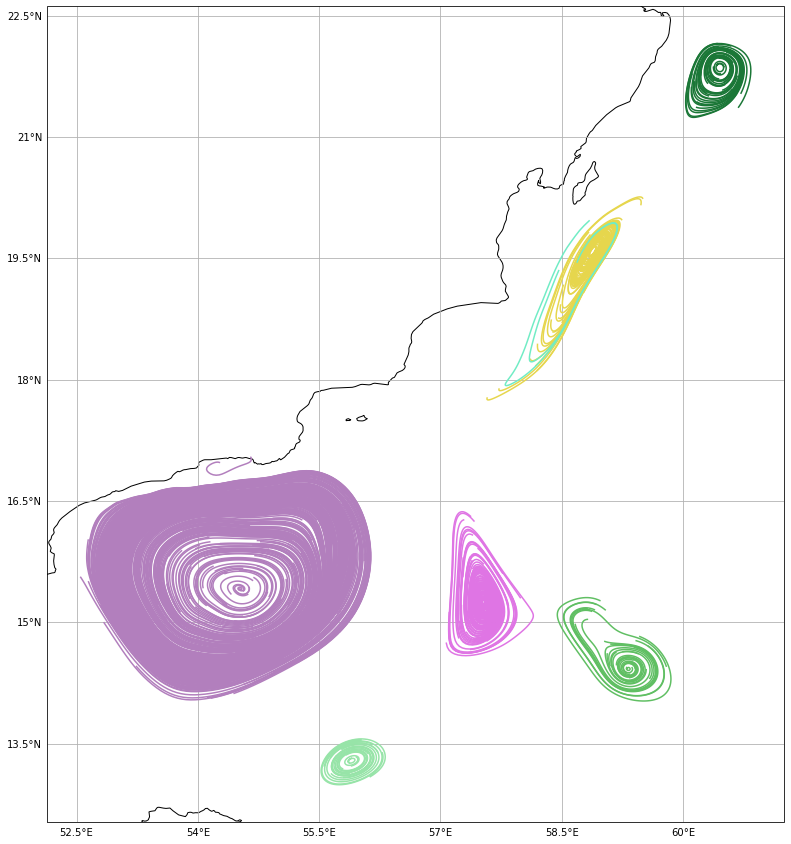

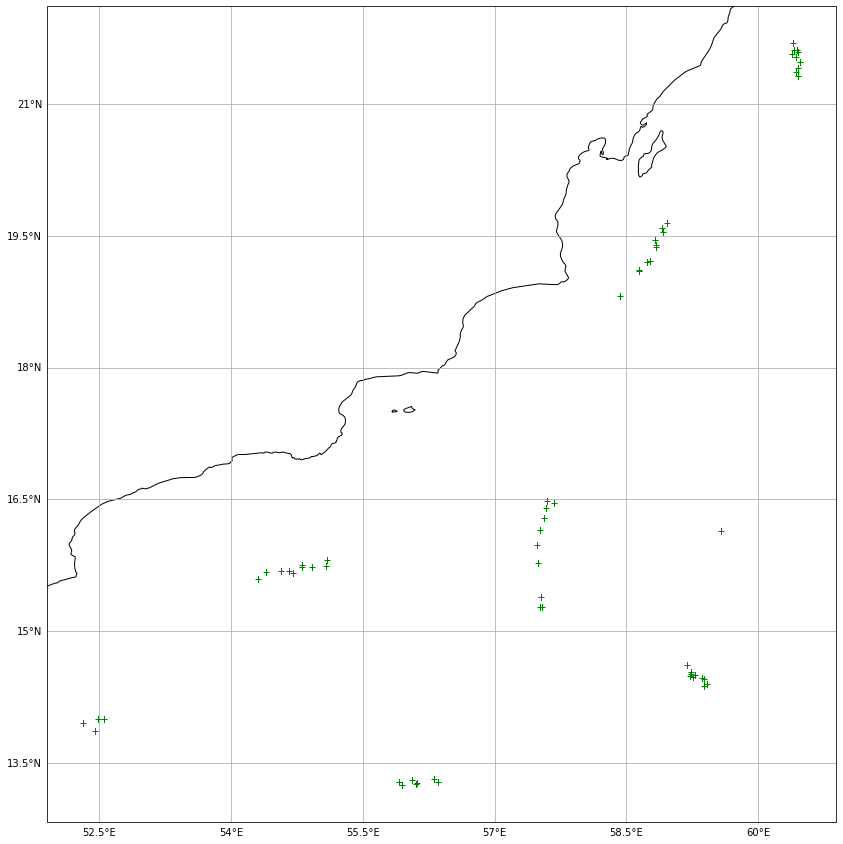

In [7]:
rd_color = lambda: '#{:02x}{:02x}{:02x}'.format(rd.randint(0,255),rd.randint(0,255),rd.randint(0,255))

for bb in new_list_path:
    figure = StreamPlot()
    for eddy in bb:
        line_style = rd_color()
        figure.plot_trajectories(eddy.sl_list,line_style=line_style)
    figure.show()

figure = StreamPlot()
for bb in new_list_path:
    figure.plot_eddies(bb,line_style='g+')

## Clustering

In [8]:
from math import *
def create_list_data(list_eddies):
    K = len(list_eddies[0])
    list_center = []
    for day in list_eddies:
        for eddies in day:
            list_center.append(eddies.center)
    return K,list_center


def calc_tho(l):
    S = np.array([0. for n in range(len(l[0]))])
    for x in l:
        S += np.array(x)
    return S/len(l)

def quadra_d (X,Y):
    S = 0
    for i in range(len(X)):
        S += (X[i]-Y[i])**2
    return sqrt(S)

def attrib_cluster(X,tho,d):
    distances = []
    for t in tho:
        dis = d(X,t)
        distances.append(d(X,t))
    i_min_d = distances.index(min(distances))
    return i_min_d


def Kmean(distance,list_eddies):
    K,list_center = create_list_data(list_eddies)
    
    cluster = [ [] for i in range(K)]
    tho = list_center[:K]
    day_eddies = [ [] for i in range(K)] # list which will save the date of each eddies
    
    tho = tho
    tho_prime = [ 0 for i in range(K)]
    tour = 0    
    
    while ( np.any(np.array(tho_prime) != np.array(tho)) and tour<1000):
        tour += 1
        
        tho_prime = tho.copy()
        cluster = [ [] for i in range(K)]
        day_eddies = [ [] for i in range(K)]
        
        for i_day in range(len(list_eddies)):
            day = list_eddies[i_day]
            for eddies in day:
                X = eddies.center
                i_min_d = attrib_cluster(X,tho,distance)
                cluster[i_min_d].append(X)
                day_eddies[i_min_d].append(i_day)
                
        for  i in range(K):
            tho[i] = calc_tho(cluster[i])
        
        cluster, day_eddies, unclass_eddies, day_unclass_eddies = clean_cluster(list_eddies, cluster, day_eddies,tho, distance)
        
        for i_eddy in range(len(unclass_eddies)):
            tho.append(unclass_eddies[i_eddy])
            cluster.append([unclass_eddies[i_eddy]])
            day_eddies.append([day_unclass_eddies[i_eddy]])
            K+=1
    
        
    return tho, cluster, day_eddies

def clean_cluster(list_eddies, clusters, day_eddies, tho, distance):
    """This function clean the cluster and add anew cluster if needed"""
    nb_day = len(list_eddies)
    new_clusters = []
    new_day_eddies = []
    unclass_eddies = []
    day_unclass_eddies = []
    for i_cluster in range(len(clusters)):
        n = len(clusters[i_cluster])
        cluster = clusters[i_cluster]
        days = day_eddies[i_cluster]
        if n>nb_day:
            for i in range(n-nb_day):
                i_max = 0
                d_max = 0
                for i_eddy in range(len(cluster)):
                    eddy = cluster[i_eddy]
                    dis = distance(eddy,tho[i_cluster])
                    if dis> d_max:
                        d_max = dis
                        i_max = i_eddy
                        
                foreign_eddy = cluster.pop(i_max)
                day_foreign_eddy = days.pop(i_max)
                unclass_eddies.append(foreign_eddy)
                day_unclass_eddies.append(day_foreign_eddy)
                
        new_clusters.append(cluster)
        new_day_eddies.append(days)
    return new_clusters, new_day_eddies, unclass_eddies, day_unclass_eddies

In [9]:
print(list_path[0][0].center)

[52.55596861 13.99970072]


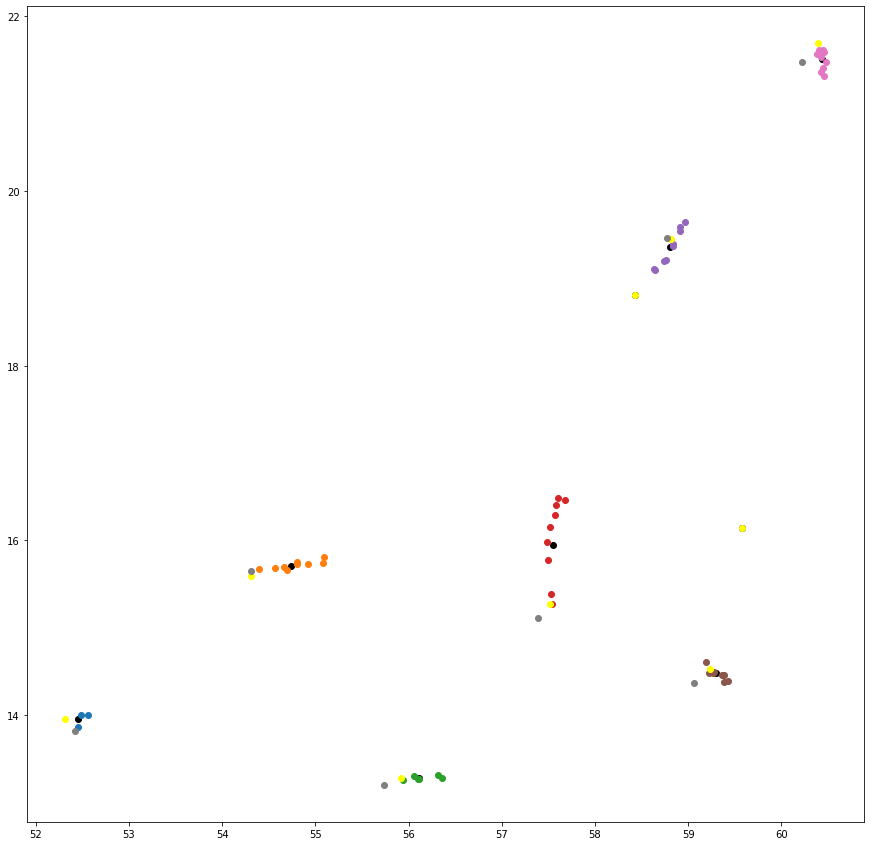

In [10]:
bary, cluster, day_eddies= Kmean(quadra_d,new_list_path)
cluster1x = []
cluster1y = []
for i in bary:
    cluster1x.append(i[0])
    cluster1y.append(i[1])

plt.scatter(cluster1x,cluster1y, c = 'black' ) 

for cl in range(len(cluster)) :
    cluster1x = []
    cluster1y = []
    for i in cluster[cl][:-1]:
        cluster1x.append(i[0])
        cluster1y.append(i[1])

    plt.scatter(cluster1x,cluster1y )
n = cluster[0]
vect = []

cluster1x = []
cluster1y = []
for cl in cluster :
    cluster1x.append(cl[-1][0])
    cluster1y.append(cl[-1][1])
plt.scatter(cluster1x,cluster1y, color = 'yellow' )


for j in range(len(cluster)):
    n = cluster[j][:-1]
    if len(n)>2:
        for i in range(len(n)-1):
            vect.append(n[i+1]-n[i])
        vect_m = sum(vect)/len(n)
        newp = n[-1]+vect_m
        plt.scatter(newp[0], newp[1], color = 'grey')

In [16]:
for i in cluster:
    print(len(i))
print("")
for i in day_eddies:
    print(len(i))


figure.plot_clusters(cluster,line_style='g+')
figure.show()

4
10
7
10
10
10
10
1
1

4
10
7
10
10
10
10
1
1
